Author: Shan Qu, Delft University of Technology

First created: 4 April 2021

Product: credit modeling --- training the model using CART tree


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

%run helpers.ipynb

pd.set_option('display.max_columns', 20)
seed = 143

import warnings
warnings.filterwarnings("ignore")

model = DecisionTreeClassifier()

In [2]:
df_X_train = pd.read_csv('df_X_train.csv')
df_X_val = pd.read_csv('df_X_val.csv')
df_y_train = pd.read_csv('df_y_train.csv')
df_y_val = pd.read_csv('df_y_val.csv')
print(df_X_train.info())
print(df_y_train.info())

# drop the unnamed ID column
df_X_train.drop('Unnamed: 0', axis=1, inplace=True)
df_X_val.drop('Unnamed: 0', axis=1, inplace=True)
df_y_train.drop('Unnamed: 0', axis=1, inplace=True)
df_y_val.drop('Unnamed: 0', axis=1, inplace=True)

df_X_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          506 non-null    int64  
 1   Age                 506 non-null    float64
 2   Credit amount       506 non-null    float64
 3   Duration            506 non-null    float64
 4   intercept           506 non-null    float64
 5   Sex_0               506 non-null    float64
 6   Job_0               506 non-null    float64
 7   Job_1               506 non-null    float64
 8   Job_2               506 non-null    float64
 9   Housing_0           506 non-null    float64
 10  Housing_1           506 non-null    float64
 11  Saving accounts_0   506 non-null    float64
 12  Saving accounts_1   506 non-null    float64
 13  Saving accounts_2   506 non-null    float64
 14  Saving accounts_3   506 non-null    float64
 15  Checking account_0  506 non-null    float64
 16  Checking

,Age,Credit amount,Duration,intercept,Sex_0,Job_0,Job_1,Job_2,Housing_0,Housing_1,...,Checking account_0,Checking account_1,Checking account_2,Purpose_0,Purpose_1,Purpose_2,Purpose_3,Purpose_4,Purpose_5,Purpose_6
0,0.089286,0.453230,0.647059,0.0,0.0,1.0,0.5,0.5,1.0,0.5,...,0.5,1.0,0.5,0.5,0.5,0.5,1.0,0.5,0.5,0.5
1,0.589286,0.108562,0.294118,0.0,1.0,1.0,0.5,0.5,1.0,0.5,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5
2,0.178571,0.170959,0.250000,0.0,0.0,1.0,0.5,0.5,1.0,0.5,...,1.0,0.5,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5
3,0.196429,0.204083,0.470588,0.0,1.0,0.5,0.5,1.0,1.0,0.5,...,1.0,0.5,0.5,0.5,0.5,1.0,0.5,0.5,0.5,0.5
4,0.982143,0.175966,0.014706,0.0,1.0,0.5,1.0,0.5,1.0,0.5,...,0.5,0.5,1.0,0.5,0.5,0.5,0.5,1.0,0.5,0.5


#### 2.1 Fine tune parameters via GridSearchCV

CART tree

max_depth: [3, 4, 5, 6],

min_samples_leaf: [0.04, 0.06, 0.08],

max_features: ['sqrt', 'log2']

In [3]:
hyperparam_grid = {'max_depth': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 4, 6, 12],
    'max_features': ['sqrt', 'log2']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid, cv=cv, scoring='f1', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

model_bestparam = grid_search.best_estimator_
print(model_bestparam)

Fitting 15 folds for each of 50 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6664409739735329
{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 12}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    2.9s finished


### 2.2 Fitting and predicting using the selected hyperparameters and visualize the results

[[96 57]
 [15 32]]
              precision    recall  f1-score   support

        good       0.86      0.63      0.73       153
         bad       0.36      0.68      0.47        47

    accuracy                           0.64       200
   macro avg       0.61      0.65      0.60       200
weighted avg       0.75      0.64      0.67       200

0.6541510221109721


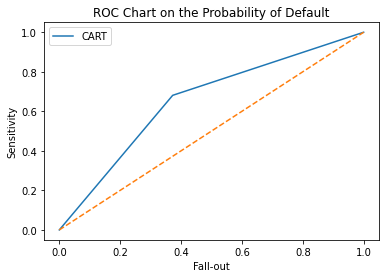

In [4]:
preds = model_bestparam.predict_proba(df_X_val)
df_preds = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.5
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds['Risk_pred']))
print(classification_report(df_y_val, df_preds['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds['Risk_pred']))

plot_roc_PD(df_preds, df_y_val, 'CART')
plt.show()

### 2.3 Select proper threshold
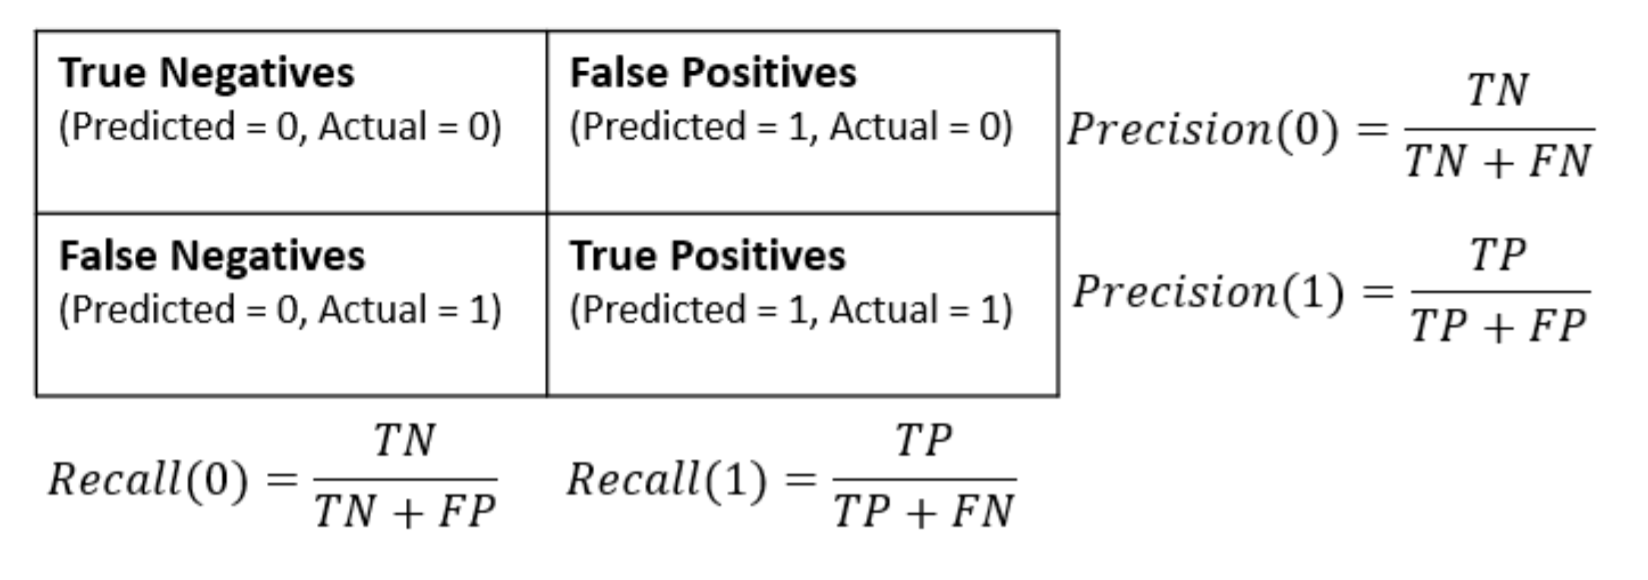

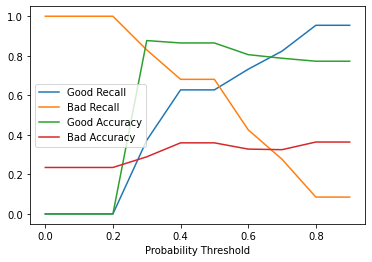

We can choose threshold = 0.65


In [5]:
plot_prob_thresh(df_preds, df_y_val)
plt.show()

print("We can choose threshold = 0.65")

### 2.4 Feature selection using feature_importances of the trained CART tree

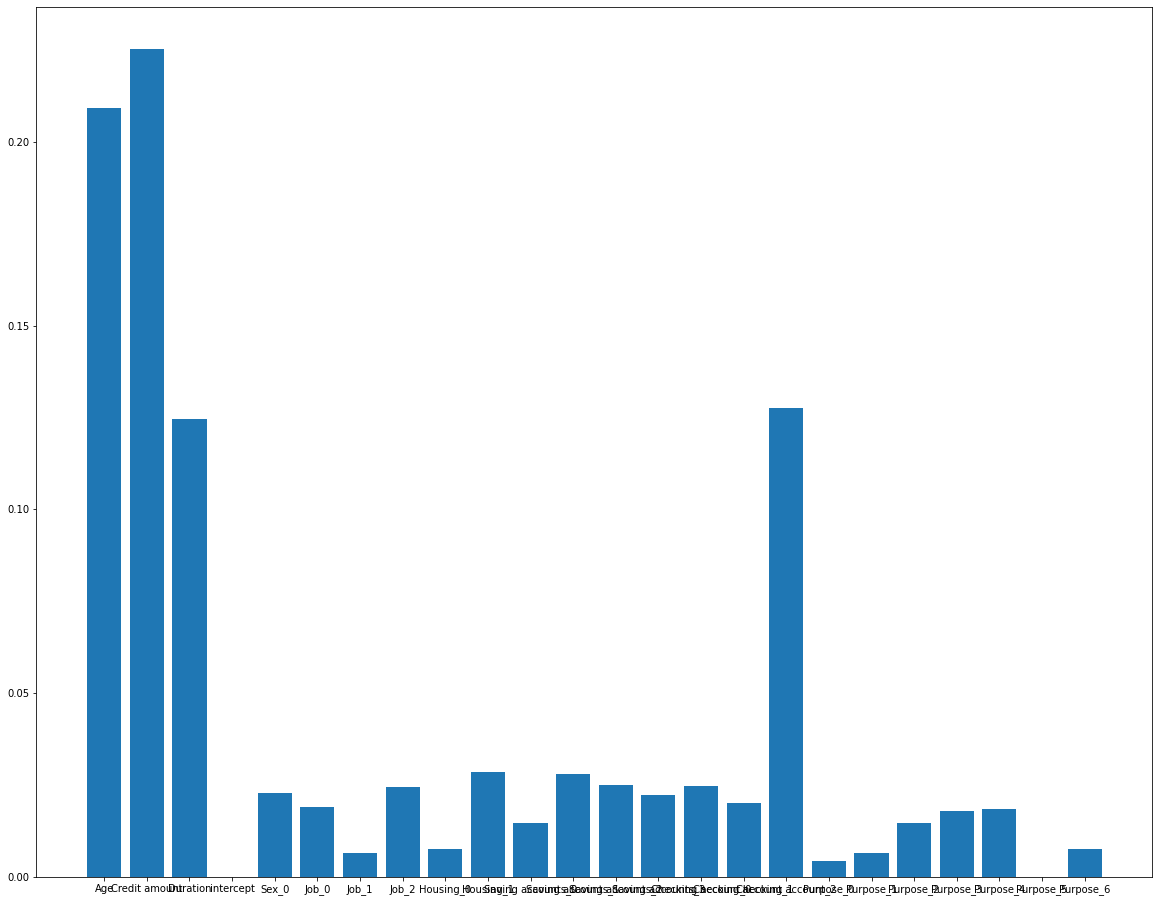

[ True  True  True False  True False False  True False  True False  True
  True  True  True  True  True False False False False False False False]
12
Index(['Age', 'Credit amount', 'Duration', 'Sex_0', 'Job_2', 'Housing_1',
       'Saving accounts_1', 'Saving accounts_2', 'Saving accounts_3',
       'Checking account_0', 'Checking account_1', 'Checking account_2'],
      dtype='object')


In [6]:
model.fit(df_X_train, np.ravel(df_y_train))
importance = model.feature_importances_
 
plt.figure(figsize=(20,16))
plt.bar([df_X_train.columns[x] for x in range(len(importance))], importance)
plt.show()

bool_selection = (importance >= np.median(importance))
print(bool_selection)
print(np.sum(bool_selection))

#selector = SelectFromModel(LogisticRegression(solver='liblinear', penalty="l1"), threshold = '1.25*median')
#selector.fit(df_X_train, df_y_train)
#print(selector.get_support())
print(df_X_train.loc[:, bool_selection].columns)
df_X_train_selected = df_X_train.loc[:, bool_selection]
df_X_val_selected = df_X_val.loc[:, bool_selection]

In [7]:
grid_search = GridSearchCV(model, param_grid=hyperparam_grid, cv=cv, scoring='f1', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

model_bestparam_selected = grid_search.best_estimator_
print(model_bestparam_selected)


Fitting 15 folds for each of 50 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6885173715126605
{'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 12}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    2.8s finished


[[65 88]
 [ 6 41]]
              precision    recall  f1-score   support

        good       0.92      0.42      0.58       153
         bad       0.32      0.87      0.47        47

    accuracy                           0.53       200
   macro avg       0.62      0.65      0.52       200
weighted avg       0.78      0.53      0.55       200

0.6485885134195523


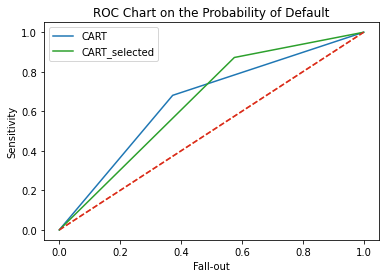

In [8]:
preds = model_bestparam_selected.predict_proba(df_X_val_selected)
df_preds_selected  = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.5
df_preds_selected['Risk_pred'] = df_preds_selected['prob_default'].apply(lambda x: 1 if x > threshold else 0)
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds_selected['Risk_pred']))
print(classification_report(df_y_val, df_preds_selected['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds_selected['Risk_pred']))

plot_roc_PD(df_preds, df_y_val, 'CART')
plot_roc_PD(df_preds_selected, df_y_val, 'CART_selected')
plt.show()

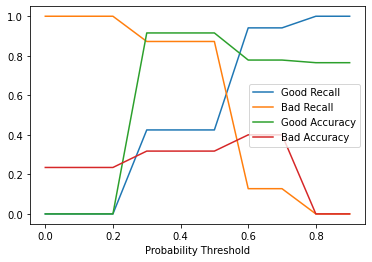

We can choose threshold = 0.62


In [9]:
plot_prob_thresh(df_preds_selected, df_y_val)
plt.show()
print("We can choose threshold = 0.62")